In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense
from keras import Input, Model

# Task 1 

In [2]:
n_timesteps_in = 70
n_timesteps_out = 60

n_features_in = 1
n_features_out = 1

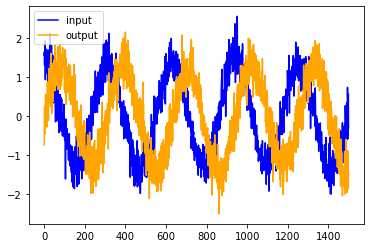

In [3]:
time_series_length = 1500
t = np.linspace(0, 10, time_series_length)

ts_output = np.sin(t) / 3 + 3 * np.sin(t*3) +  0.8 * np.random.standard_normal(size=time_series_length)
ts_input = np.cos(t) / 3 + 4 * np.cos(t*3) + 0.9 * np.random.standard_normal(size=time_series_length)

ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'blue', label = 'input')
plt.plot(ts_norm_output,'orange', label = 'output')

plt.legend()

In [4]:
train_size = int(len(ts_input) * 0.8)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]

In [5]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)
    test_input_data, test_output_data = [], []
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)

In [6]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()

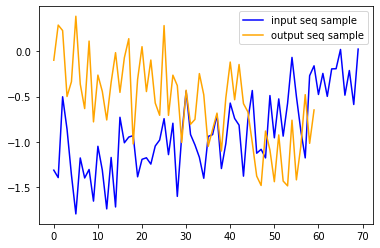

In [7]:
plt.plot(train_input_data[0], 'blue', label = 'input seq sample')
plt.plot(train_output_data[0], 'orange', label = 'output seq sample')
plt.legend()

In [8]:
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))

In [9]:
n_units = 128

encoder_inputs = Input(shape=(n_timesteps_in, n_features_in))
encoder = LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

decoder_inputs = Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
decoder_dense = Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [10]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        66560       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [11]:
model.compile(optimizer='adam', loss='mse')

In [12]:
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = my_callbacks, verbose=2)

Epoch 1/100
7/7 - 6s - loss: 0.9867 - val_loss: 0.9055 - 6s/epoch - 865ms/step
Epoch 2/100
7/7 - 1s - loss: 0.7720 - val_loss: 0.6778 - 1s/epoch - 161ms/step
Epoch 3/100
7/7 - 1s - loss: 0.6635 - val_loss: 0.6684 - 967ms/epoch - 138ms/step
Epoch 4/100
7/7 - 1s - loss: 0.6436 - val_loss: 0.5870 - 968ms/epoch - 138ms/step
Epoch 5/100
7/7 - 1s - loss: 0.5410 - val_loss: 0.2913 - 962ms/epoch - 137ms/step
Epoch 6/100
7/7 - 1s - loss: 0.3214 - val_loss: 0.3068 - 993ms/epoch - 142ms/step
Epoch 7/100
7/7 - 1s - loss: 0.2575 - val_loss: 0.2289 - 1s/epoch - 144ms/step
Epoch 8/100
7/7 - 1s - loss: 0.2332 - val_loss: 0.2186 - 995ms/epoch - 142ms/step
Epoch 9/100
7/7 - 1s - loss: 0.2011 - val_loss: 0.1811 - 951ms/epoch - 136ms/step
Epoch 10/100
7/7 - 1s - loss: 0.1732 - val_loss: 0.2296 - 1s/epoch - 170ms/step
Epoch 11/100
7/7 - 1s - loss: 0.1919 - val_loss: 0.1782 - 1s/epoch - 187ms/step
Epoch 12/100
7/7 - 1s - loss: 0.1757 - val_loss: 0.1449 - 1s/epoch - 198ms/step
Epoch 13/100
7/7 - 1s - loss: 0

In [13]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])

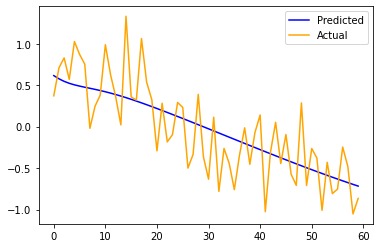

In [14]:
plt.plot(y_pred[0], 'blue', label = 'Predicted')
plt.plot(test_output_data[0], 'orange', label = 'Actual')

plt.legend()

# Task 2

In [24]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from keras.datasets import fashion_mnist

In [25]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [26]:
dim = 784; 
x_train = x_train.reshape(60000, dim);
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

In [27]:
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [28]:
def build_discriminator(): 
    model =  keras.Sequential()
    
    model.add(layers.Dense(1000, input_dim=dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)));
    model.add(layers.LeakyReLU(alpha=0.2));
    model.add(layers.Dropout(0.3));
     
    model.add(layers.Dense(512));
    model.add(layers.LeakyReLU(alpha=0.2));
    model.add(layers.Dropout(0.3));

    model.add(layers.Dense(256));
    model.add(layers.LeakyReLU(alpha=0.2));
    model.add(layers.Dropout(0.3));

    model.add(layers.Dense(150));
    model.add(layers.LeakyReLU(alpha=0.2));
    model.add(layers.Dropout(0.3));

    model.add(layers.Dense(1, activation='sigmoid'));
    model.compile(loss='binary_crossentropy', optimizer=optim);
    return model;

In [29]:
def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(150, input_dim=100, kernel_initializer=initializers.RandomNormal(stddev=0.02)));
    model.add(layers.LeakyReLU(alpha=0.2));

    model.add(layers.Dense(256));
    model.add(layers.LeakyReLU(alpha=0.2));

    model.add(layers.Dense(512));
    model.add(layers.LeakyReLU(alpha=0.2));
    
    model.add(layers.Dense(1000));
    model.add(layers.LeakyReLU(alpha=0.2));

    model.add(layers.Dense(dim, activation='tanh'));

    model.compile(loss='binary_crossentropy', optimizer=optim);
    return model;

In [30]:
discriminator = build_discriminator();
generator = build_generator();

discriminator.trainable = False;
gan_input = keras.Input(shape=(100,));
x = generator(gan_input);
gan_output = discriminator(x);
gan = keras.Model(inputs=gan_input, outputs=gan_output);
gan.compile(loss='binary_crossentropy', optimizer=optim);

In [31]:
def plot_generated_images(epoch, generator):
    num_of_images = 7;
    noise = np.random.normal(0, 1, size=[num_of_images, 100]);
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28);
    plt.figure();
    for i in range(num_of_images):
        plt.subplot(1, 7, i+1);
        plt.imshow(generated_images[i], cmap = 'gray');
        plt.axis('off');
        plt.tight_layout();
    plt.show()

In [36]:
discrim_losses = [];

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size);
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, 100]);
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)];
            
            # Generate fake images
            generated_images = generator.predict(noise);
            X = np.concatenate([image_batch, generated_images]);

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size);
            y_dis[:batch_size] = 0.9; 
            # Train discriminator
            discriminator.trainable = True;
            d_loss = discriminator.train_on_batch(X, y_dis);
            discrim_losses.append(d_loss);

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, 100]);
            y_gen = np.ones(batch_size);
            discriminator.trainable = False;
            gan.train_on_batch(noise, y_gen);
        if ep % 10 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator);

epoch:  0


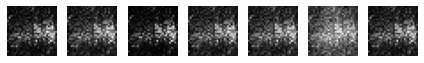

epoch:  10


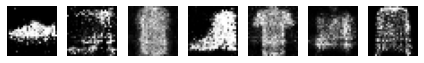

epoch:  20


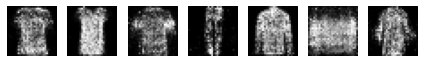

epoch:  30


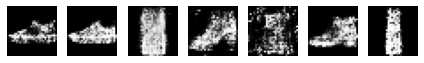

epoch:  40


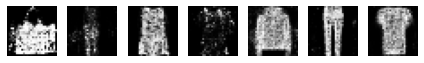

epoch:  50


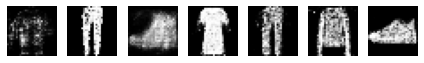

epoch:  60


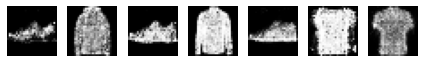

epoch:  70


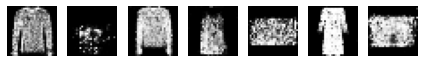

epoch:  80


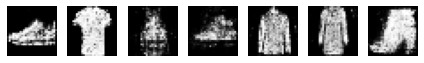

epoch:  90


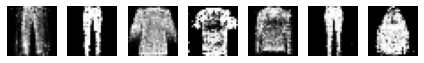

epoch:  100


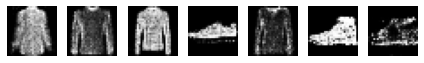

In [37]:
epochs = 100;
batch_size = 256;
train_model(epochs, batch_size);

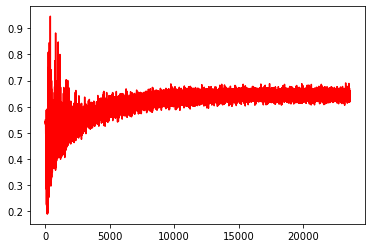

In [39]:
plt.plot(discrim_losses, color='r');